In [14]:
import sys
import numpy as np
import pandas as pd

from matplotlib.pyplot import imread
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K

from sklearn.utils import shuffle

import numpy.random as rng

### Please give below paths as per the paths in your system

In [17]:
train_folder = "../images_background/"
val_folder = '../images_evaluation/'
save_path = '../data/'

In [16]:
#len(train_folder)
len(val_folder)

21

In [10]:
#from scipy.misc.pilutil import imread

In [11]:
def loadimgs(path,n = 0):
    
    path ="F:/internship proj/one_shot_simence/images_background"

    X=[]
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n
    # we load every alphabet seperately so we can isolate them later
    for alphabet in os.listdir(path):
        print("loading alphabet: " + alphabet)
        lang_dict[alphabet] = [curr_y,None]
        alphabet_path = os.path.join(path,alphabet)
        # every letter/category has it's own column in the array, so  load seperately
        for letter in os.listdir(alphabet_path):
            cat_dict[curr_y] = (alphabet, letter)
            category_images=[]
            letter_path = os.path.join(alphabet_path, letter)
            # read all the images in the current category
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = imread(image_path)
                category_images.append(image)
                y.append(curr_y)
            try:
                X.append(np.stack(category_images))
            # edge case  - last one
            except ValueError as e:
                print(e)
                print("error - category_images:", category_images)
            curr_y += 1
            lang_dict[alphabet][1] = curr_y - 1
    y = np.vstack(y)
    X = np.stack(X)
    return X,y,lang_dict

### Loading the train images into tensors

In [12]:
X,y,c=loadimgs(train_folder)

loading alphabet: Alphabet_of_the_Magi
loading alphabet: Anglo-Saxon_Futhorc
loading alphabet: Arcadian
loading alphabet: Armenian
loading alphabet: Asomtavruli_(Georgian)
loading alphabet: Balinese
loading alphabet: Bengali
loading alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
loading alphabet: Braille
loading alphabet: Burmese_(Myanmar)
loading alphabet: Cyrillic
loading alphabet: Early_Aramaic
loading alphabet: Futurama
loading alphabet: Grantha
loading alphabet: Greek
loading alphabet: Gujarati
loading alphabet: Hebrew
loading alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)
loading alphabet: Japanese_(hiragana)
loading alphabet: Japanese_(katakana)
loading alphabet: Korean
loading alphabet: Latin
loading alphabet: Malay_(Jawi_-_Arabic)
loading alphabet: Mkhedruli_(Georgian)
loading alphabet: N_Ko
loading alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)
loading alphabet: Sanskrit
loading alphabet: Syriac_(Estrangelo)
loading alphabet: Tagalog
loading alphabet: Tifinagh


In [13]:
X.shape

(964, 20, 105, 105)

In [9]:
y.shape

(19280, 1)

In [10]:
c.keys()

dict_keys(['Alphabet_of_the_Magi', 'Anglo-Saxon_Futhorc', 'Arcadian', 'Armenian', 'Asomtavruli_(Georgian)', 'Balinese', 'Bengali', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Braille', 'Burmese_(Myanmar)', 'Cyrillic', 'Early_Aramaic', 'Futurama', 'Grantha', 'Greek', 'Gujarati', 'Hebrew', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Japanese_(hiragana)', 'Japanese_(katakana)', 'Korean', 'Latin', 'Malay_(Jawi_-_Arabic)', 'Mkhedruli_(Georgian)', 'N_Ko', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Sanskrit', 'Syriac_(Estrangelo)', 'Tagalog', 'Tifinagh'])

In [11]:
c['Sanskrit']

[827, 868]

In [12]:
c['Alphabet_of_the_Magi']

[0, 19]

### Saving the train tensors on disk

In [39]:
'''
import pickle
with open(os.path.join("train.pickle", "wb") as f:
    pickle.dump((X,c),f)'''
    

'\nimport pickle\nwith open(os.path.join("train.pickle", "wb") as f:\n    pickle.dump((X,c),f)'

In [38]:
import pickle

pickle_out = open("train.pickle","wb")
pickle.dump((X,c), pickle_out)
pickle_out.close()

### Loading the validation images into tensors

In [13]:
Xval,yval,cval=loadimgs(val_folder)

loading alphabet: Alphabet_of_the_Magi
loading alphabet: Anglo-Saxon_Futhorc
loading alphabet: Arcadian
loading alphabet: Armenian
loading alphabet: Asomtavruli_(Georgian)
loading alphabet: Balinese
loading alphabet: Bengali
loading alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
loading alphabet: Braille
loading alphabet: Burmese_(Myanmar)
loading alphabet: Cyrillic
loading alphabet: Early_Aramaic
loading alphabet: Futurama
loading alphabet: Grantha
loading alphabet: Greek
loading alphabet: Gujarati
loading alphabet: Hebrew
loading alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)
loading alphabet: Japanese_(hiragana)
loading alphabet: Japanese_(katakana)
loading alphabet: Korean
loading alphabet: Latin
loading alphabet: Malay_(Jawi_-_Arabic)
loading alphabet: Mkhedruli_(Georgian)
loading alphabet: N_Ko
loading alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)
loading alphabet: Sanskrit
loading alphabet: Syriac_(Estrangelo)
loading alphabet: Tagalog
loading alphabet: Tifinagh


### Saving the validation tensors on disk

In [43]:
#with open(os.path.join(save_path,"val.pickle"), "wb") as f:
 #   pickle.dump((Xval,cval),f)
    
    
import pickle

pickle_out = open("val.pickle","wb")
pickle.dump((Xval,cval), pickle_out)
pickle_out.close()

In [14]:
# del X, y ,c ,Xval, yval, cval

from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng

In [11]:
def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)
#//TODO: figure out how to initialize layer biases in keras.
def b_init(shape,name=None):
    """Initialize bias as in paper"""
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

input_shape = (105, 105, 1)
left_input = Input(input_shape)
right_input = Input(input_shape)
#build convnet to use in each siamese 'leg'
convnet = Sequential()
convnet.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape,
                   kernel_initializer=W_init,kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(7,7),activation='relu',
                   kernel_regularizer=l2(2e-4),kernel_initializer=W_init,bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(Flatten())
convnet.add(Dense(4096,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=W_init,bias_initializer=b_init))

#call the convnet Sequential model on each of the input tensors so params will be shared
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)
#layer to merge two encoded inputs with the l1 distance between them
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
#call this layer on list of two input tensors.
L1_distance = L1_layer([encoded_l, encoded_r])
prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(L1_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

optimizer = Adam(0.00006)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer)

siamese_net.count_params()


TypeError: W_init() got an unexpected keyword argument 'dtype'

In [15]:
def initialize_weights(shape, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

In [16]:
def initialize_bias(shape, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [17]:
def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [18]:
model = get_siamese_model((105, 105, 1))
model.summary()

W0809 01:52:34.827771  3164 deprecation_wrapper.py:119] From H:\anaconda\lib\site-packages\keras\backend\tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4096)         38947648    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 4096)         0           sequential_1[1][0]         

In [16]:
from IPython.display import Image
Image(retina=True, filename='model.png')

FileNotFoundError: [Errno 2] No such file or directory: 'model.png'

In [19]:
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

W0809 01:53:05.663167  3164 deprecation.py:323] From H:\anaconda\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Loading the train tensors

In [21]:
with open("train.pickle", "rb") as f:
    (Xtrain, train_classes) = pickle.load(f)
    
print("Training alphabets: \n")
print(list(train_classes.keys()))

Training alphabets: 

['Alphabet_of_the_Magi', 'Anglo-Saxon_Futhorc', 'Arcadian', 'Armenian', 'Asomtavruli_(Georgian)', 'Balinese', 'Bengali', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Braille', 'Burmese_(Myanmar)', 'Cyrillic', 'Early_Aramaic', 'Futurama', 'Grantha', 'Greek', 'Gujarati', 'Hebrew', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Japanese_(hiragana)', 'Japanese_(katakana)', 'Korean', 'Latin', 'Malay_(Jawi_-_Arabic)', 'Mkhedruli_(Georgian)', 'N_Ko', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Sanskrit', 'Syriac_(Estrangelo)', 'Tagalog', 'Tifinagh']


In [22]:
with open( "val.pickle", "rb") as f:
    (Xval, val_classes) = pickle.load(f)

print("Validation alphabets:", end="\n\n")
print(list(val_classes.keys()))

Validation alphabets:

['Alphabet_of_the_Magi', 'Anglo-Saxon_Futhorc', 'Arcadian', 'Armenian', 'Asomtavruli_(Georgian)', 'Balinese', 'Bengali', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Braille', 'Burmese_(Myanmar)', 'Cyrillic', 'Early_Aramaic', 'Futurama', 'Grantha', 'Greek', 'Gujarati', 'Hebrew', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Japanese_(hiragana)', 'Japanese_(katakana)', 'Korean', 'Latin', 'Malay_(Jawi_-_Arabic)', 'Mkhedruli_(Georgian)', 'N_Ko', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Sanskrit', 'Syriac_(Estrangelo)', 'Tagalog', 'Tifinagh']


In [23]:
def get_batch(batch_size,s="train"):
    """Create batch of n pairs, half same class, half different class"""
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    n_classes, n_examples, w, h = X.shape

    # randomly sample several classes to use in the batch
    categories = rng.choice(n_classes,size=(batch_size,),replace=False)
    
    # initialize 2 empty arrays for the input image batch
    pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
    
    # initialize vector for the targets
    targets=np.zeros((batch_size,))
    
    # make one half of it '1's, so 2nd half of batch has same class
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = rng.randint(0, n_examples)
        pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
        idx_2 = rng.randint(0, n_examples)
        
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category  
        else: 
            # add a random number to the category modulo n classes to ensure 2nd image has a different category
            category_2 = (category + rng.randint(1,n_classes)) % n_classes
        
        pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
    
    return pairs, targets

In [24]:
def generate(batch_size, s="train"):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size,s)
        yield (pairs, targets)

In [25]:
def make_oneshot_task(N, s="val", language=None):
    """Create pairs of test image, support set for testing N way one-shot learning. """
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    n_classes, n_examples, w, h = X.shape
    
    indices = rng.randint(0, n_examples,size=(N,))
    if language is not None: # if language is specified, select characters for that language
        low, high = categories[language]
        if N > high - low:
            raise ValueError("This language ({}) has less than {} letters".format(language, N))
        categories = rng.choice(range(low,high),size=(N,),replace=False)

    else: # if no language specified just pick a bunch of random letters
        categories = rng.choice(range(n_classes),size=(N,),replace=False)            
    true_category = categories[0]
    ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
    test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
    support_set = X[categories,indices,:,:]
    support_set[0,:,:] = X[true_category,ex2]
    support_set = support_set.reshape(N, w, h,1)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image,support_set]

    return pairs, targets

In [26]:
def test_oneshot(model, N, k, s = "val", verbose = 0):
    """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N,s)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct+=1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
    return percent_correct

In [56]:
# Hyper parameters
evaluate_every = 200 # interval for evaluating on one-shot tasks
batch_size = 16
n_iter = 20 # No. of training iterations
N_way = 20 # how many classes for testing one-shot tasks
n_val = 250 # how many one-shot tasks to validate on
best = -1

In [53]:
model_path = '../weights/'

In [57]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    (inputs,targets) = get_batch(batch_size)
    loss = model.train_on_batch(inputs, targets)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc = test_oneshot(model, N_way, n_val, verbose=True)
        model.save_weights('weights.{}.h5'.format(i))
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc

Starting training process!
-------------------------------------


### Load model weights

In [16]:
model.load_weights(os.path.join(model_path, "weights.20000.h5"))

### Testing

### Baseline model based on Nearest Neighbors using Euclidean distance (L2 distance)

In [35]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0

In [36]:
def test_nn_accuracy(N_ways,n_trials):
    """Returns accuracy of NN approach """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials

In [37]:
ways = np.arange(1,20,2)
resume =  False
trials = 50

In [38]:
val_accs, train_accs,nn_accs = [], [], []
for N in ways:    
    val_accs.append(test_oneshot(model, N, trials, "val", verbose=True))
    train_accs.append(test_oneshot(model, N, trials, "train", verbose=True))
    nn_acc = test_nn_accuracy(N, trials)
    nn_accs.append(nn_acc)
    print ("NN Accuracy = ", nn_acc)
    print("---------------------------------------------------------------------------------------------------------------")

Evaluating model on 50 random 1 way one-shot learning tasks ... 

Got an average of 100.0% 1 way one-shot learning accuracy 

Evaluating model on 50 random 1 way one-shot learning tasks ... 

Got an average of 100.0% 1 way one-shot learning accuracy 

Evaluating nearest neighbour on 50 unique 1 way one-shot learning tasks ...
NN Accuracy =  100.0
---------------------------------------------------------------------------------------------------------------
Evaluating model on 50 random 3 way one-shot learning tasks ... 



H:\anaconda\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


Got an average of 70.0% 3 way one-shot learning accuracy 

Evaluating model on 50 random 3 way one-shot learning tasks ... 

Got an average of 70.0% 3 way one-shot learning accuracy 

Evaluating nearest neighbour on 50 unique 3 way one-shot learning tasks ...
NN Accuracy =  26.0
---------------------------------------------------------------------------------------------------------------
Evaluating model on 50 random 5 way one-shot learning tasks ... 

Got an average of 58.0% 5 way one-shot learning accuracy 

Evaluating model on 50 random 5 way one-shot learning tasks ... 

Got an average of 62.0% 5 way one-shot learning accuracy 

Evaluating nearest neighbour on 50 unique 5 way one-shot learning tasks ...
NN Accuracy =  16.0
---------------------------------------------------------------------------------------------------------------
Evaluating model on 50 random 7 way one-shot learning tasks ... 

Got an average of 40.0% 7 way one-shot learning accuracy 

Evaluating model on 50 ra

### Save the accuracies on disk

In [39]:
with open("accuracies.pickle", "wb") as f:
    pickle.dump((val_accs,train_accs,nn_accs),f)

### Load the accuracies from disk

In [40]:
with open("accuracies.pickle", "rb") as f:
    (val_accs, train_accs, nn_accs) = pickle.load(f)

### Below two functions are used for visualizing test image and support set

In [41]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, h , w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img

In [42]:
def plot_oneshot_task(pairs):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.matshow(pairs[0][0].reshape(105,105), cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

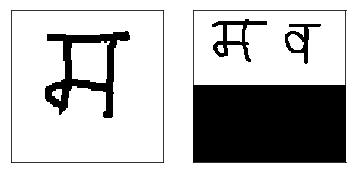

In [48]:
# Example of concat image visualization
pairs, targets = make_oneshot_task(2,"train","Sanskrit")
plot_oneshot_task(pairs)

### Resuts

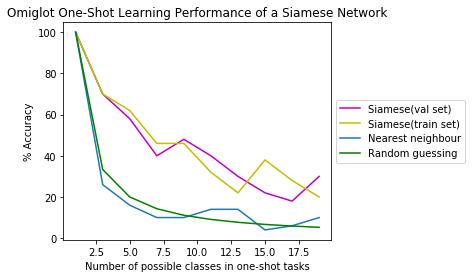

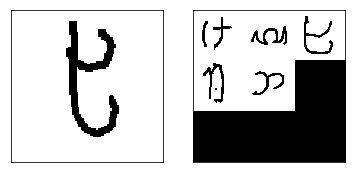

In [50]:
fig,ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
ax.plot(ways, train_accs, "y", label="Siamese(train set)")
plt.plot(ways, nn_accs, label="Nearest neighbour")

ax.plot(ways, 100.0/ways, "g", label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = make_oneshot_task(5, "val")
plt.show()

plot_oneshot_task(inputs)